In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [127]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            #for addition, the gradient is simply backpropagated
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            #for multiplication, it's the global derivative times the other data
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other - 1)) * out.grad

        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            #for tanh, it's 1 - tan^2x times global derivative
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self, ), 'exp')

        def _backward():
            self.grad = out.data * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [20]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [134]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(7.0, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

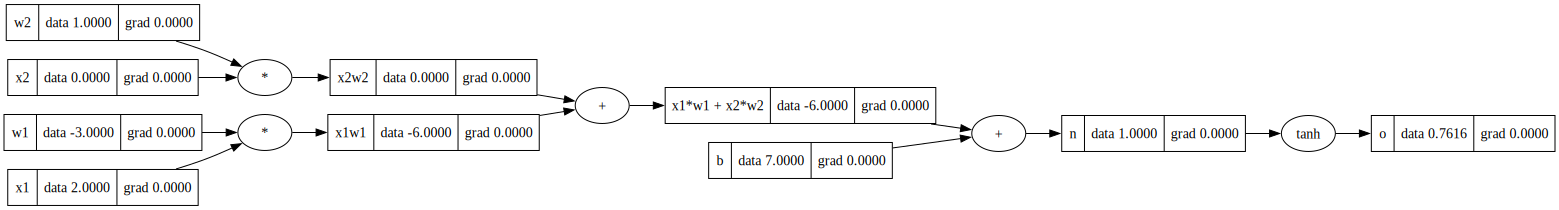

In [135]:
draw_dot(o)

In [136]:
o.grad = 1.0
o._backward()

In [137]:
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

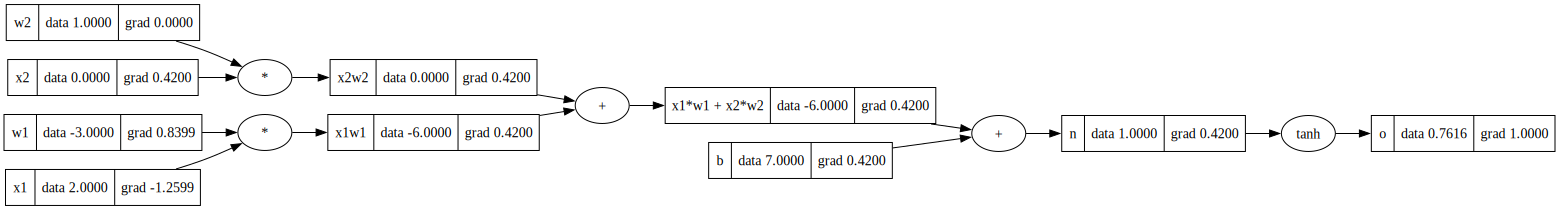

In [138]:
draw_dot(o)

In [30]:
#topological sort makes it so that all the arrows in our graph only go in one direction
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=7.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.7615941559557649)]

In [ ]:
#taking all of the above together, once a forward pass is done, this is what we need to do
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


In [38]:
x1 - x2

Value(data=2.0)

In [139]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

b = Value(7.0, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'
o.backward()

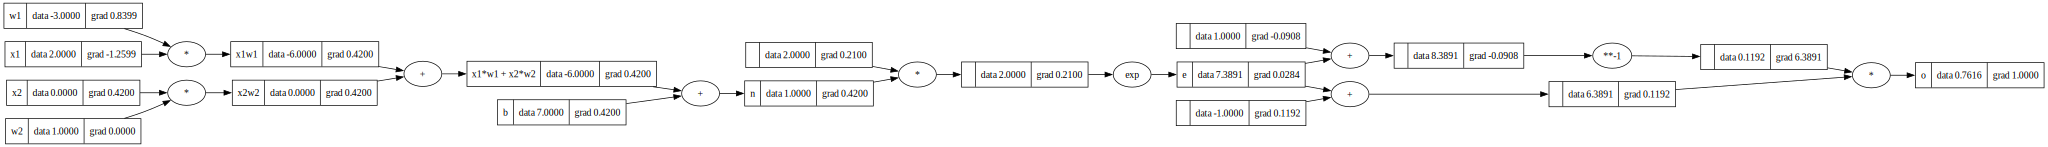

In [140]:
draw_dot(o)

In [48]:
import torch

In [49]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([7.0]).double(); b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('w1', w1.data.item())
print('w2', w2.data.item())
print('x1', x1.data.item())
print('x2', x2.data.item())

0.7615941559557649
w1 -3.0
w2 1.0
x1 2.0
x2 0.0


In [141]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [142]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.8224285820525363)

In [143]:
n.parameters()

[Value(data=-0.28103912535754194),
 Value(data=0.5062026942348992),
 Value(data=-0.015522166358453049),
 Value(data=-0.24416938158753276),
 Value(data=-0.4984041810465263),
 Value(data=-0.45344920836657665),
 Value(data=0.7323638199933706),
 Value(data=-0.9140617949611638),
 Value(data=0.025162217543599708),
 Value(data=0.012098985639366067),
 Value(data=-0.011212263241988651),
 Value(data=0.8319436671825717),
 Value(data=-0.45533908521465905),
 Value(data=-0.7453456457759335),
 Value(data=0.5851540287086492),
 Value(data=-0.4688175077307517),
 Value(data=0.1160286325140849),
 Value(data=-0.06838882145950387),
 Value(data=-0.8740732605522201),
 Value(data=0.9965015518161631),
 Value(data=-0.9449927989013547),
 Value(data=-0.18969739130531482),
 Value(data=0.11390254621073148),
 Value(data=0.7087500797456243),
 Value(data=0.47040696492494605),
 Value(data=0.6410683009367788),
 Value(data=0.7859012207880272),
 Value(data=-0.3365634753057545),
 Value(data=-0.6376650074695192),
 Value(data

In [144]:
#toy dataset

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

ypreds = [n(x) for x in xs]
ypreds

[Value(data=-0.8224285820525363),
 Value(data=-0.41957110183796026),
 Value(data=-0.7044668673706171),
 Value(data=-0.7424049931780584)]

In [145]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(data=6.781458635237184)

In [146]:
loss.backward()

In [147]:
n.layers[0].neurons[0].w[0]

Value(data=-0.28103912535754194)

In [148]:
n.layers[0].neurons[0].w[0].grad

0.7814088752947115

In [149]:
loss

Value(data=6.781458635237184)

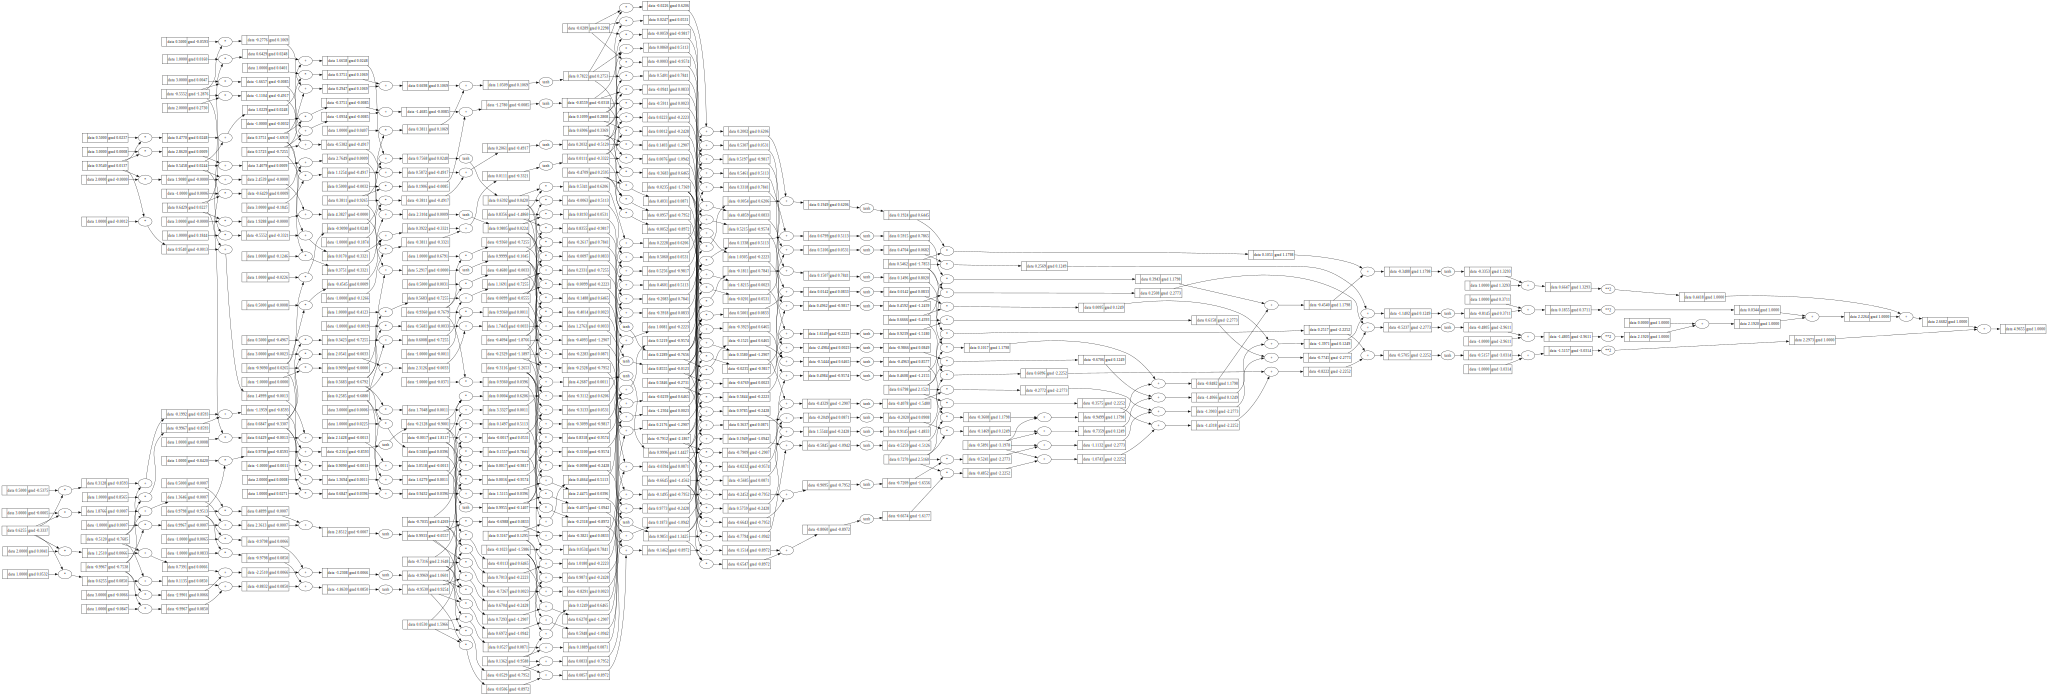

In [91]:
draw_dot(loss)

In [150]:
len(n.parameters())

41

In [151]:
loss

Value(data=6.781458635237184)

In [178]:
#gradient descent
for p in n.parameters():
    p.data += -0.01 * p.grad

In [179]:
#forward pass
ypreds = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(data=4.527678196881727)

Our loss has decreased a little

In [216]:
#keep iterating, and our weights improve to get us closer to the target labels
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad
    p.grad = 0.0
ypreds = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(data=2.202340272139266)

In [217]:
ypreds

[Value(data=0.36691525138148506),
 Value(data=-0.7247270561663047),
 Value(data=0.12604363277723726),
 Value(data=0.3233948591084519)]

Let's define all this properly as a training routine

In [221]:
#data definition
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

n = MLP(3, [4,4,1])

lr = 0.01

for k in range(30):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update weights
    for p in n.parameters():
        p.data += -lr * p.grad

    print('epoch: ', k, 'loss: ', loss.data)


epoch:  0 loss:  7.4364377961898676
epoch:  1 loss:  7.037076660741525
epoch:  2 loss:  6.66761576746226
epoch:  3 loss:  6.308475888568601
epoch:  4 loss:  5.946743656146753
epoch:  5 loss:  5.576172232190346
epoch:  6 loss:  5.1962637560539555
epoch:  7 loss:  4.810493484291392
epoch:  8 loss:  4.424094277405078
epoch:  9 loss:  4.042440599252732
epoch:  10 loss:  3.6706443741667236
epoch:  11 loss:  3.3138099752883465
epoch:  12 loss:  2.9769734545690216
epoch:  13 loss:  2.664425194235422
epoch:  14 loss:  2.3789083942513334
epoch:  15 loss:  2.121295968041231
epoch:  16 loss:  1.890883450479076
epoch:  17 loss:  1.6859981223541345
epoch:  18 loss:  1.5045618248631787
epoch:  19 loss:  1.3444341616002737
epoch:  20 loss:  1.2035506840139791
epoch:  21 loss:  1.0799476120555593
epoch:  22 loss:  0.9717541582565736
epoch:  23 loss:  0.8771926889210815
epoch:  24 loss:  0.7945934076631348
epoch:  25 loss:  0.7224151468016846
epoch:  26 loss:  0.6592626633639316
epoch:  27 loss:  0.603

In [222]:
ypred

[Value(data=0.7576939040905476),
 Value(data=-0.5483959032381077),
 Value(data=-0.687897972081287),
 Value(data=0.6098094454249207)]